# Healthcare Final Project (Fall 2023): Prediction and Data Visualization of Sepsis
### Yihan Li (yl10798) Yantao Luo (yl5929)

In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

## 1. Data Analysis and Preprocessing

In [2]:
sepsis_df = pd.read_csv('Dataset.csv')
sepsis_df = sepsis_df.drop(columns='Unnamed: 0')
sepsis_df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [3]:
# Drop Administrative Data
columns_to_drop = ['Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
sepsis_df = sepsis_df.drop(columns=columns_to_drop)

In [4]:
nan_percentage = sepsis_df.isnull().mean() * 100
threshold = 50

# Get columns where the percentage of NaN values is greater than the threshold
high_nan_columns = nan_percentage[nan_percentage > threshold]
print("Columns with more than 50% NaN values:")
print(high_nan_columns)

Columns with more than 50% NaN values:
Temp                66.162697
EtCO2               96.286843
BaseExcess          94.579020
HCO3                95.810618
FiO2                91.665754
pH                  93.069688
PaCO2               94.440121
SaO2                96.549372
AST                 98.377604
BUN                 93.134434
Alkalinephos        98.393194
Calcium             94.116067
Chloride            95.460279
Creatinine          93.904433
Bilirubin_direct    99.807371
Glucose             82.894325
Lactate             97.329872
Magnesium           93.689578
Phosphate           95.986303
Potassium           90.689082
Bilirubin_total     98.509158
TroponinI           99.047745
Hct                 91.145979
Hgb                 92.617558
PTT                 97.055875
WBC                 93.593199
Fibrinogen          99.340167
Platelets           94.059502
dtype: float64


### 1.1 Data Inspection

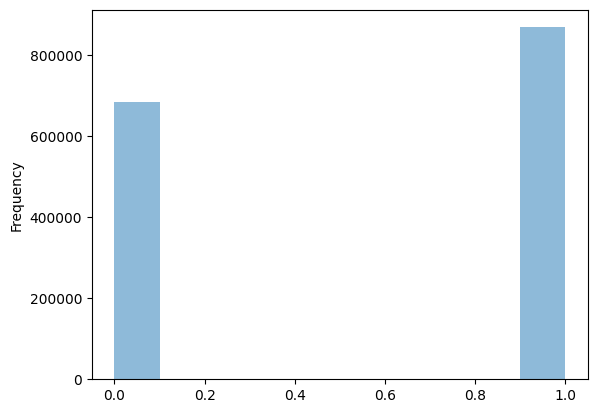

In [5]:
sepsis_df.Gender.plot.hist(alpha=0.5);

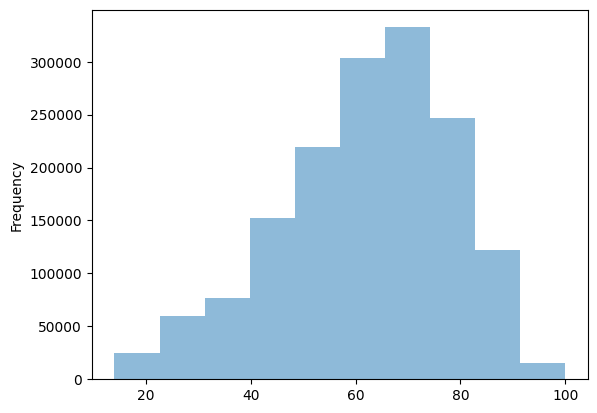

In [6]:
sepsis_df.Age.plot.hist(alpha=0.5);

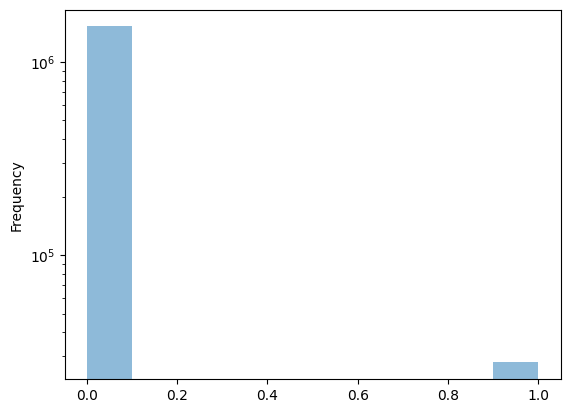

In [7]:
sepsis_df.SepsisLabel.plot.hist(alpha=0.5, logy=True);

### 1.2 Data Imputation

In [8]:
grouped_by_patient = sepsis_df.groupby('Patient_ID')
sepsis_df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
sepsis_df.head()
# grouped_by_patient = sepsis_df.groupby('Patient_ID')
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer()
# imputer.fit(sepsis_df)
# sepsis_df = grouped_by_patient.apply(lambda x: pd.DataFrame(imputer.transform(x), columns=sepsis_df.columns))
# sepsis_df.head()

C:\Users\liyihan\AppData\Local\Temp\ipykernel_10460\1270594311.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sepsis_df = grouped_by_patient.apply(lambda x: x.bfill().ffill())


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,SepsisLabel,Patient_ID
0,0,65.0,100.0,35.78,129.0,72.0,69.0,16.5,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072
1,1,65.0,100.0,35.78,129.0,72.0,69.0,16.5,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072
2,2,78.0,100.0,35.78,129.0,42.5,69.0,17.0,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072
3,3,73.0,100.0,35.78,129.0,74.0,69.0,17.0,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072
4,4,70.0,100.0,35.78,129.0,74.0,69.0,14.0,NaN,6.0,...,29.7,9.5,30.6,11.3,NaN,330.0,68.54,0,0,17072


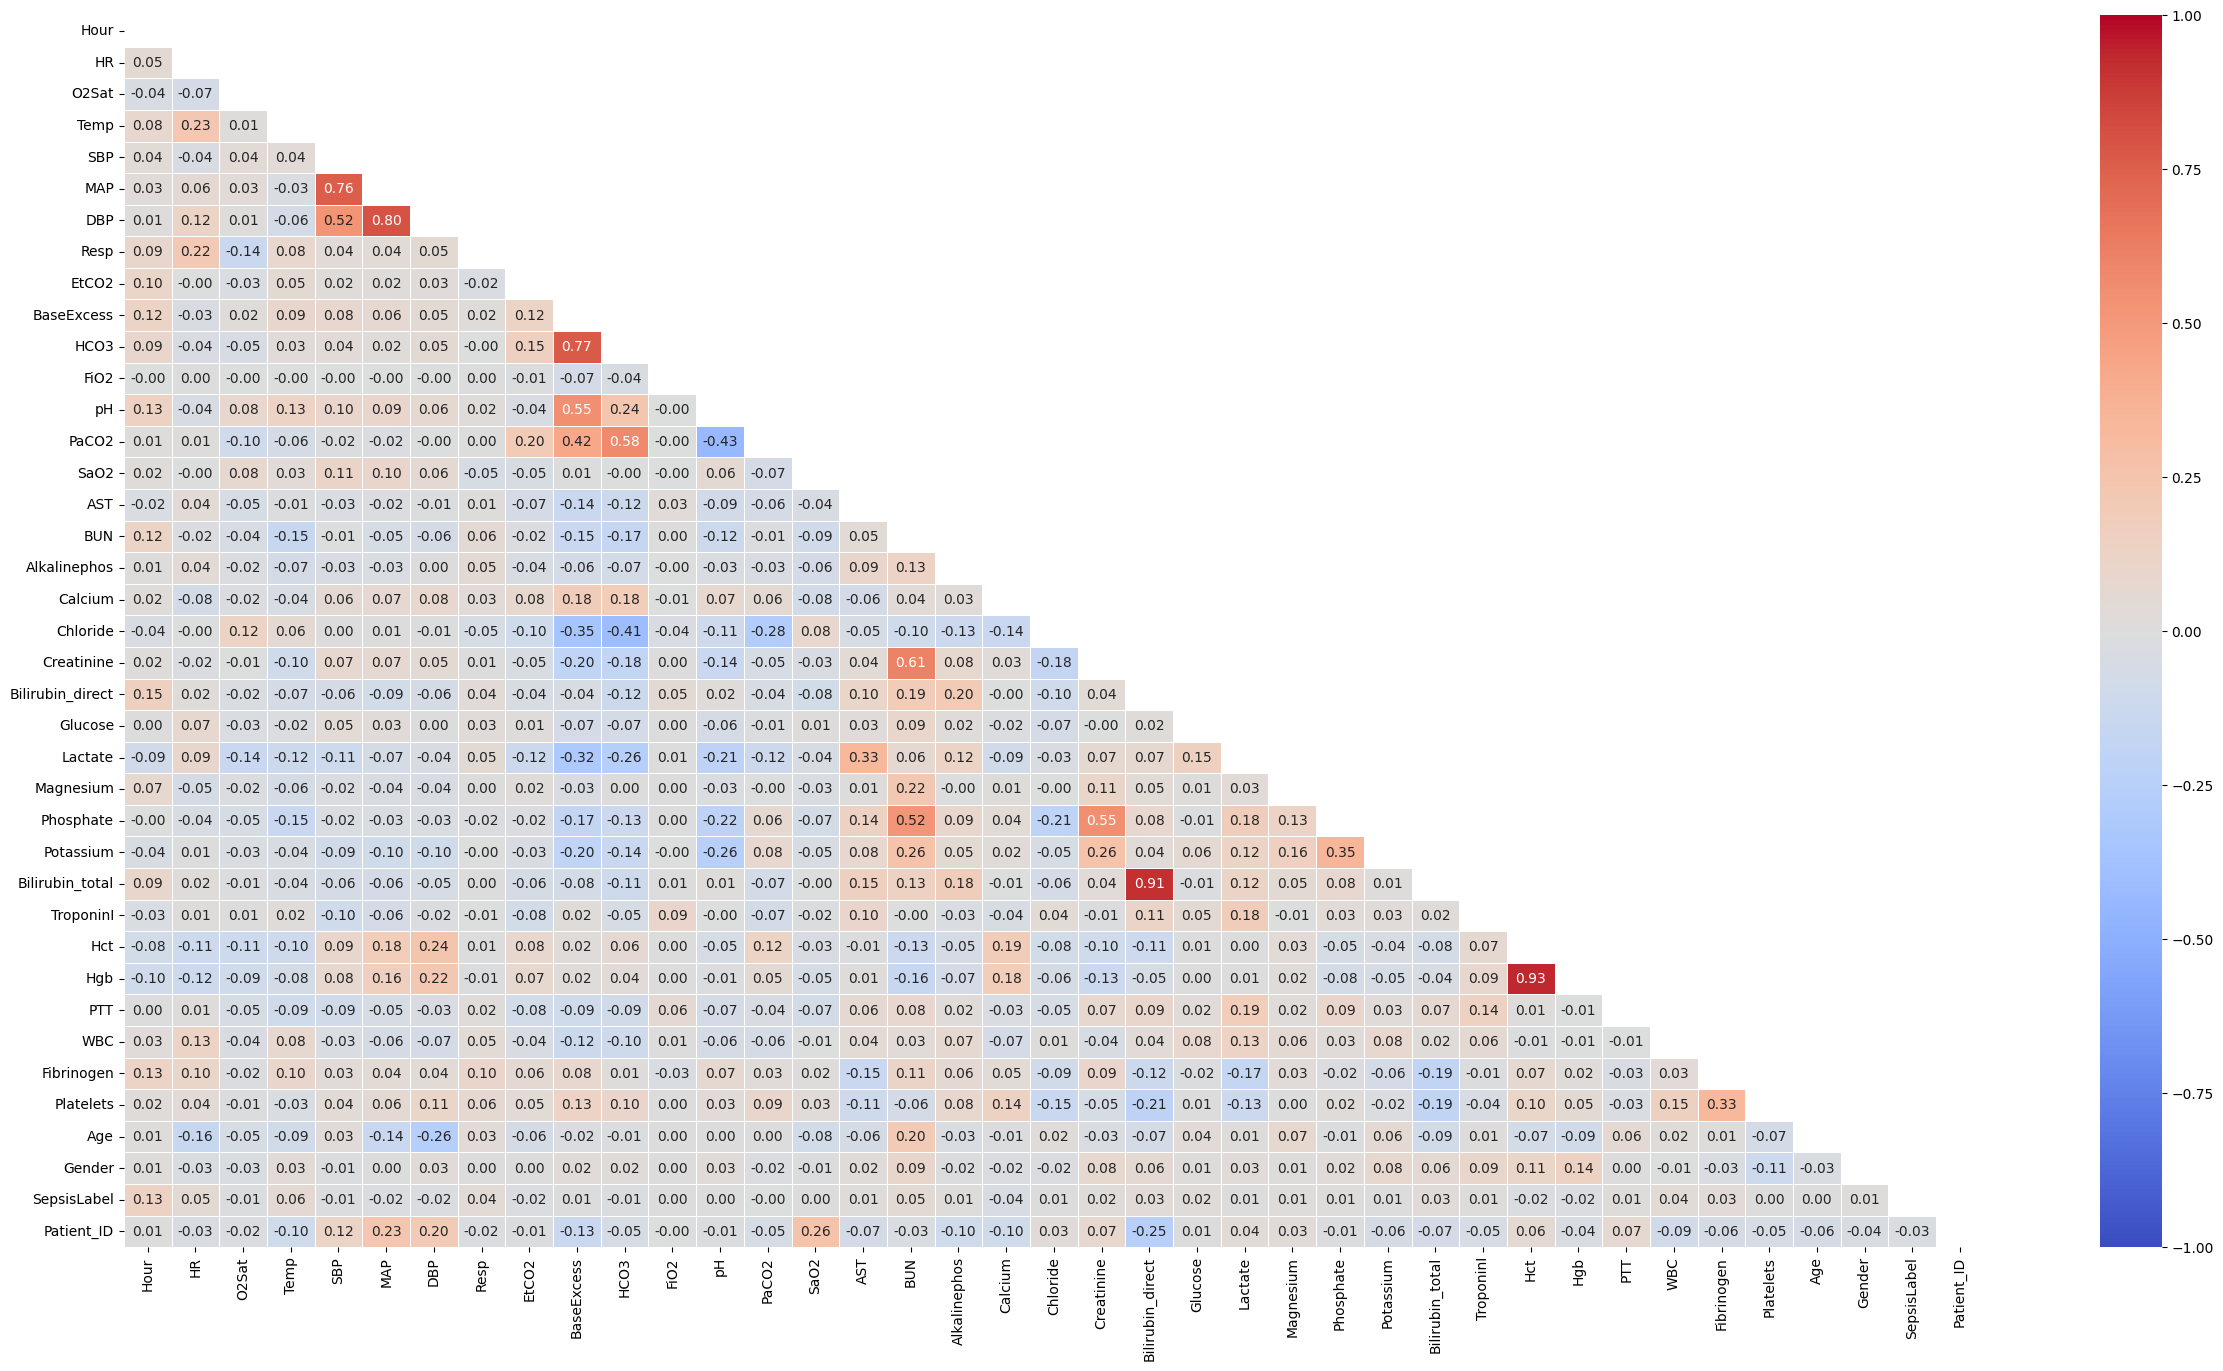

In [9]:
# correlation matrix to check the correlation between the remaining features
correlation_matrix = sepsis_df.corr()
plt.figure(figsize=(30, 16))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, 
            annot=True,       # Add correlation values to the squares
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)),
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Set the scale for the color bar
            fmt='.2f',        # Formatting numbers
            linewidths=.5)    # Space between cells

plt.show()

In [10]:
# columns = sepsis_df.columns

# # Create an empty DataFrame to store the p-values
# p_values = pd.DataFrame(index=columns, columns=columns)

# # Loop through the columns and calculate the p-values
# for col in columns:
#     # Calculate the Pearson correlation coefficient and the p-value
#     corr_test = pearsonr(sepsis_df['SepsisLabel'], sepsis_df[col])
#     # Assign the p-value to the correct position in the DataFrame
#     p_values.loc['SepsisLabel', col] = corr_test[1]

# # Convert all the p-value entries from objects to floats
# p_values = p_values.astype(float)

### 1.3 Sampling Train Set and Test Set

In [11]:
# Split training set and test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(sepsis_df, test_size=0.3, train_size=0.7, random_state=1124, shuffle=True, stratify=None)
train_set.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,SepsisLabel,Patient_ID
984763,30,80.0,100.0,34.30,123.0,81.00,59.0,16.5,NaN,-2.8,...,19.0,7.5,NaN,6.3,359.0,88.0,64.00,0,0,114780
436170,21,77.0,100.0,35.78,114.5,39.00,41.5,18.0,NaN,NaN,...,29.9,9.4,NaN,16.4,NaN,293.0,73.15,1,0,7226
602113,10,89.0,100.0,37.39,117.0,86.00,70.0,21.0,NaN,5.0,...,28.1,9.9,37.7,7.2,NaN,131.0,72.59,1,0,6513
61412,54,113.0,95.0,37.61,125.0,87.00,68.0,23.0,NaN,4.0,...,35.4,12.3,25.1,19.6,199.0,176.0,35.43,1,0,5427
240186,14,89.0,96.0,37.72,129.0,60.33,NaN,19.0,NaN,NaN,...,25.4,8.7,35.7,16.0,NaN,265.0,70.76,0,0,10345


In [12]:
pos_set = train_set[train_set.SepsisLabel == 1]
neg_set = train_set[train_set.SepsisLabel == 0]
neg_set = neg_set.sample(frac = 0.1)
train_set = pd.concat([pos_set,neg_set])

y_train = train_set.SepsisLabel
X_train = train_set.drop(columns=['SepsisLabel', 'Patient_ID'])
y_test = test_set.SepsisLabel
X_test = test_set.drop(columns=['SepsisLabel', 'Patient_ID'])

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
    X_train[i] = np.log(X_train[i]+1)
    X_test[i] = np.log(X_test[i]+1)
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# print(sorted(Counter(y_resampled).items()))
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_imputed, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 91347), (1, 106082)]


### 1.4 Correlation Analysis

#### KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

k = 2
model = KNeighborsClassifier(n_neighbors=k)
scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = scaler.transform(X_resampled)
model.fit(X_resampled, y_resampled)

# x_test = test_set.drop(columns=["Patient_ID", "SepsisLabel"])
X_test = scaler.transform(X_test_imputed)
y_test = test_set.SepsisLabel
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9485250062813666
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    457254
           1       0.26      0.98      0.41      8409

    accuracy                           0.95    465663
   macro avg       0.63      0.96      0.69    465663
weighted avg       0.99      0.95      0.96    465663



#### Logistic Regression

In [14]:
# Impute missing values using mean for numerical columns
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

D:\work\miniconda3\envs\nerf\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


Accuracy: 0.9811924073847396
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    457254
           1       0.02      0.00      0.00      8409

    accuracy                           0.98    465663
   macro avg       0.50      0.50      0.50    465663
weighted avg       0.96      0.98      0.97    465663



In [15]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=10798)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
importances = forest.feature_importances_
print('Importances: ', importances)
indices = np.argsort(importances)[::-1]
print('Importance sort:', indices)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(22, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1)
    def forward(self, X):
        X = self.linear1(X)
        X = F.leaky_relu(X)
        X = self.linear2(X)
        X = F.leaky_relu(X)
        X = self.linear3(X)
        return torch.sigmoid(X)
        


In [ ]:
from torch.utils.data import DataLoader, Dataset
class SepsisDataset(Dataset):
    def __init__(self, flag='train', X=None, y=None):
        assert flag in ['train', 'test', 'valid']
        self.flag = flag
        self.X = X
        self.y = y

    def __getitem__(self, index):
        
        return self.X[index, :], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]


train_set = np.concatenate([X_train, np.expand_dims(y_train, axis=1)], axis=1)
train_set, valid_set = train_test_split(train_set, test_size=0.1, train_size=0.9, random_state=10798, shuffle=True, stratify=None)
X_train = train_set[:,:-1]
y_train = train_set[:,-1:]
X_valid = valid_set[:,:-1]
y_valid = valid_set[:,-1:]
y_test = np.expand_dims(y_test, axis=1)

train_dataset = SepsisDataset(flag='train', X=X_train, y=y_train)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_dataset = SepsisDataset(flag='valid', X=X_valid, y=y_valid)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
test_dataset = SepsisDataset(flag='test', X=X_test, y=y_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [ ]:
model = FCN().to('cuda:0')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []


In [ ]:
from tqdm import tqdm
num_epochs = 200

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_dataloader,0):
        data_x = data_x.to(torch.float32).to('cuda:0')
        data_y = data_y.to(torch.float32).to('cuda:0')
        outputs = model(data_x)
        optimizer.zero_grad()
        loss = criterion(data_y,outputs)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
#         if idx%(len(train_dataloader)//2)==0:
#             print("epoch={}/{},{}/{}of train, loss={}".format(
#                 epoch, num_epochs, idx, len(train_dataloader),loss.item()))
    train_epochs_loss.append(np.average(train_epoch_loss))
    
    #=====================valid============================
    model.eval()
    valid_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(valid_dataloader,0):
        data_x = data_x.to(torch.float32).to('cuda:0')
        data_y = data_y.to(torch.float32).to('cuda:0')
        outputs = model(data_x)
        loss = criterion(data_y,outputs)
        valid_epoch_loss.append(loss.item())
        valid_loss.append(loss.item())
    valid_epochs_loss.append(np.average(valid_epoch_loss))


In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
plt.plot(valid_epochs_loss[1:],'-o',label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
val = torch.tensor(X_test).reshape(1, -1).float().to("cuda:0")
# 需要转换成相应的输入shape，而且得带上batch_size，因此转换成shape=(1,1)这样的形状
results = [0, 0, 0, 0] # FN, FP, TN, TP
for idx,(data_x,data_y) in enumerate(test_dataloader,0):
    target = int(data_y.item())
    data_x = data_x.to(torch.float32).to('cuda:0')
    data_y = data_y.to(torch.float32).to('cuda:0')
    res0 = model(data_x)
    res = 1 if res0.item() > 0.5 else 0
    TF = 1 if res == data_y else 0
    results[TF * 2 + res] += 1
#     if ((idx+1) % 1000 == 0):
#         print(results, data_y.item(), res0.item(), res)
    
pos_precision = results[3] / (results[3] + results[1])
pos_recall = results[3] / (results[3] + results[0])
neg_precision = results[2] / (results[2] + results[0])
neg_recall = results[2] / (results[2] + results[1])
print("Precision            Recall")
print("pos_precision     pos_recall")
print("neg_precision     neg_recall")

In [ ]:
print("Precision            Recall")
print(pos_precision,   pos_recall)
print(neg_precision,   neg_recall)